In [1]:
import os, shutil
# 1. Find nvcc and set CUDA_HOME dynamically if it’s not already set
nvcc_path = shutil.which("nvcc")
if nvcc_path:
    cuda_root = os.path.dirname(os.path.dirname(nvcc_path))
    os.environ["CUDA_HOME"] = cuda_root
    print("CUDA_HOME set to:", cuda_root)
else:
    print("nvcc not found on PATH—CUDA_HOME remains unset")

# 2. Point XLA at the libdevice folder (only needed if you got libdevice errors)
os.environ["XLA_FLAGS"] = f"--xla_gpu_cuda_data_dir={os.environ.get('CUDA_HOME','')}"

# 3. Verify ptxas is available
ptxas = shutil.which("ptxas")
print("ptxas at:", ptxas if ptxas else "not found")

# 4. Now import TF and list devices
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  # 0=all logs, 1=filter INFO, 2=filter WARNING, 3=filter ERROR
import tensorflow as tf
print("Built with CUDA:", tf.test.is_built_with_cuda())
print("Physical GPUs:", tf.config.list_physical_devices("GPU"))

# 5. Run a tiny GPU workload with placement logging
tf.debugging.set_log_device_placement(False)
with tf.device("/GPU:0"):
    a = tf.random.uniform((256,256))
    b = tf.random.uniform((256,256))
    c = tf.matmul(a, b)
print("Result is on:", c.device)

CUDA_HOME set to: /home/mcw77/.conda/envs/test_env
ptxas at: /home/mcw77/.conda/envs/test_env/bin/ptxas


2025-05-16 12:51:30.773410: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-05-16 12:51:30.773447: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-05-16 12:51:30.773455: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Built with CUDA: True
Physical GPUs: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:2', device_type='GPU')]
Result is on: /job:localhost/replica:0/task:0/device:GPU:0


In [3]:
import os
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colormaps
import tensorflow_addons as tfa
plt.style.use('ggplot')

In [4]:
# 1) Parameters
IMG_SIZE = (512, 512)
BATCH_SIZE = 32
AUTOTUNE = tf.data.AUTOTUNE
file_dir = 'VarBrAngle_StdDev/'
all_files = tf.io.gfile.listdir(file_dir)
#only want tif
all_files = [f for f in all_files if f[-3:] == 'tif']

In [53]:
len(all_files)

3268

In [5]:
def parse_angle_tf(fname):
    # fname: a scalar string tensor, e.g. ".../BrAngle-20.tiff"
    parts     = tf.strings.split(fname, 'BrAngle-')
    angle_str = tf.strings.split(parts[-1], '.')[0]
    angle     = tf.strings.to_number(angle_str, out_type=tf.int32)
    return angle  # shape=()
    
def _load_tiff_with_pil(path_bytes):
    # path_bytes is a bytes tensor → numpy bytes
    path = path_bytes.numpy().decode()
    full = os.path.join(file_dir, path)
    with Image.open(full) as img:
        # don't convert to "L" (8-bit) — keep full bit depth
        img = img.resize(IMG_SIZE, Image.BILINEAR)
        arr = np.array(img, dtype=np.float32) / 65535.0
    # add channel dim
    return arr.reshape((*IMG_SIZE, 1))

def load_and_preprocess(fname):
    img = tf.py_function(
        func=_load_tiff_with_pil,
        inp=[fname],
        Tout=tf.float32)
    img.set_shape([*IMG_SIZE, 1])
    label = parse_angle_tf(fname)
    return img, label

# 4. a small augmentation pipeline
def augment(image, label):
    return image, label

In [6]:
# split your filenames once
batch_size = 10

n = len(all_files)
train_filenames = all_files[: int(0.8*n)]
val_filenames   = all_files[int(0.8*n):]


# 5. build your datasets
train_ds = (tf.data.Dataset
    .from_tensor_slices(train_filenames)
    .map(load_and_preprocess, num_parallel_calls=tf.data.AUTOTUNE)
    .map(augment,               num_parallel_calls=tf.data.AUTOTUNE)
    .shuffle(1024)
    .batch(batch_size)
    .prefetch(tf.data.AUTOTUNE)
)

val_ds = (tf.data.Dataset
    .from_tensor_slices(val_filenames)
    .map(load_and_preprocess, num_parallel_calls=tf.data.AUTOTUNE)
    .batch(batch_size)
    .prefetch(tf.data.AUTOTUNE)
)

In [7]:
# pick one filename
sample = train_filenames[7]
print(sample)
# 1) load + preprocess
img, lbl = load_and_preprocess(sample)
print("After load/preprocess:", img.shape, img.dtype,
      "min/max =", tf.reduce_min(img).numpy(), tf.reduce_max(img).numpy(),
      "label =", lbl.numpy())

# 2) augment
aug_img, aug_lbl = augment(img, lbl)
print("After augment:    ", aug_img.shape, aug_img.dtype,
      "min/max =", tf.reduce_min(aug_img).numpy(), tf.reduce_max(aug_img).numpy(),
      "label =", aug_lbl.numpy())

Skeleton-Sample-396-BrAngle-100.00.tif
After load/preprocess: (512, 512, 1) <dtype: 'float32'> min/max = 0.0 1.0 label = 100
After augment:     (512, 512, 1) <dtype: 'float32'> min/max = 0.0 1.0 label = 100


In [8]:
train_ds.cardinality().numpy()

262

In [13]:
he = tf.keras.initializers.HeNormal(seed = 1234321)
l2 = tf.keras.regularizers.l2(1e-4)

def build_conv_model():
    return tf.keras.Sequential([
        # input: 512×512 grayscale
        tf.keras.layers.Input((512, 512, 1)),

        # Stem: 512→128 via a big strided conv
        tf.keras.layers.Conv2D(
            32, kernel_size=7, strides=4, padding='same',
            activation=None,
            kernel_initializer=he,
            kernel_regularizer=l2
        ),
        tf.keras.layers.BatchNormalization(momentum=0.9),
        tf.keras.layers.Activation('swish'),
        tf.keras.layers.SpatialDropout2D(0.1),

        # Block 1: 128→64
        tf.keras.layers.Conv2D(
            64, kernel_size=3, strides=2, padding='same',
            activation=None,
            kernel_initializer=he,
            kernel_regularizer=l2
        ),
        tf.keras.layers.BatchNormalization(momentum=0.9),
        tf.keras.layers.Activation('swish'),
        tf.keras.layers.SpatialDropout2D(0.1),

        # Block 2:  64→32
        tf.keras.layers.Conv2D(
            128, kernel_size=3, strides=2, padding='same',
            activation=None,
            kernel_initializer=he,
            kernel_regularizer=l2
        ),
        tf.keras.layers.BatchNormalization(momentum=0.9),
        tf.keras.layers.Activation('swish'),
        tf.keras.layers.SpatialDropout2D(0.1),

        # Block 3:  32→16
        tf.keras.layers.Conv2D(
            256, kernel_size=3, strides=2, padding='same',
            activation=None,
            kernel_initializer=he,
            kernel_regularizer=l2
        ),
        tf.keras.layers.BatchNormalization(momentum=0.9),
        tf.keras.layers.Activation('swish'),
        tf.keras.layers.SpatialDropout2D(0.1),

        # Global pool + dense head
        tf.keras.layers.GlobalAveragePooling2D(),

        tf.keras.layers.Dense(
            128, activation=None,
            kernel_initializer=he,
            kernel_regularizer=l2
        ),
        tf.keras.layers.BatchNormalization(momentum=0.9),
        tf.keras.layers.Activation('swish'),
        tf.keras.layers.Dropout(0.3),

        tf.keras.layers.Dense(
            64, activation=None,
            kernel_initializer=he,
            kernel_regularizer=l2
        ),
        tf.keras.layers.BatchNormalization(momentum=0.9),
        tf.keras.layers.Activation('swish'),
        tf.keras.layers.Dropout(0.3),

        tf.keras.layers.Dense(
            32, activation=None,
            kernel_initializer=he,
            kernel_regularizer=l2
        ),
        tf.keras.layers.BatchNormalization(momentum=0.9),
        tf.keras.layers.Activation('swish'),
        tf.keras.layers.Dropout(0.3),

        # Final continuous output in [0, 180]
        tf.keras.layers.Dense(
            1, activation='sigmoid',
            kernel_initializer=he,
            kernel_regularizer=l2
        ),
        tf.keras.layers.Lambda(lambda x: x * 180.0, name='angle_deg')
    ])

In [14]:
model = build_conv_model()
model.compile(optimizer='adam',
              loss='mean_squared_error',
              metrics=['mean_absolute_error'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 32)      1600      
                                                                 
 batch_normalization (Batch  (None, 128, 128, 32)      128       
 Normalization)                                                  
                                                                 
 activation (Activation)     (None, 128, 128, 32)      0         
                                                                 
 spatial_dropout2d (Spatial  (None, 128, 128, 32)      0         
 Dropout2D)                                                      
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 64)        18496     
                                                                 
 batch_normalization_1 (Bat  (None, 64, 64, 64)        2

(512, 512, 1)
(512, 512, 1)
(512, 512, 1)
(512, 512, 1)


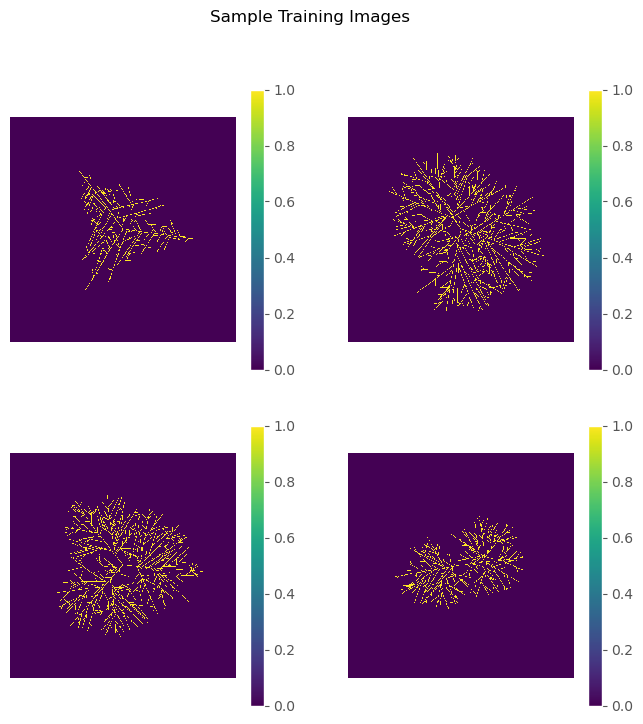

In [15]:
plt.figure(figsize=(8,8))
for i, (img, lbl) in enumerate(train_ds.unbatch().take(4)):
    plt.subplot(2,2,i+1)
    print(img.shape)
    plt.imshow(img.numpy().squeeze(), interpolation='nearest')
    plt.colorbar()
    plt.axis('off')

plt.suptitle("Sample Training Images")
plt.show()

In [16]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=40
)

Epoch 1/40


2025-05-16 12:56:33.931789: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential/spatial_dropout2d/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


262/262 [==============================] - 17s 33ms/step - loss: 1167.2220 - mean_absolute_error: 27.0273 - val_loss: 483.9159 - val_mean_absolute_error: 18.0838
Epoch 2/40
262/262 [==============================] - 10s 31ms/step - loss: 832.0734 - mean_absolute_error: 22.6392 - val_loss: 459.3256 - val_mean_absolute_error: 16.5220
Epoch 3/40
262/262 [==============================] - 10s 31ms/step - loss: 786.5250 - mean_absolute_error: 22.0145 - val_loss: 422.1030 - val_mean_absolute_error: 16.5454
Epoch 4/40
262/262 [==============================] - 10s 31ms/step - loss: 685.6339 - mean_absolute_error: 20.5174 - val_loss: 419.7113 - val_mean_absolute_error: 15.9071
Epoch 5/40
262/262 [==============================] - 10s 31ms/step - loss: 656.3702 - mean_absolute_error: 20.0766 - val_loss: 352.7032 - val_mean_absolute_error: 14.6606
Epoch 6/40
262/262 [==============================] - 10s 29ms/step - loss: 662.4696 - mean_absolute_error: 19.9452 - val_loss: 353.1905 - val_mean_ab

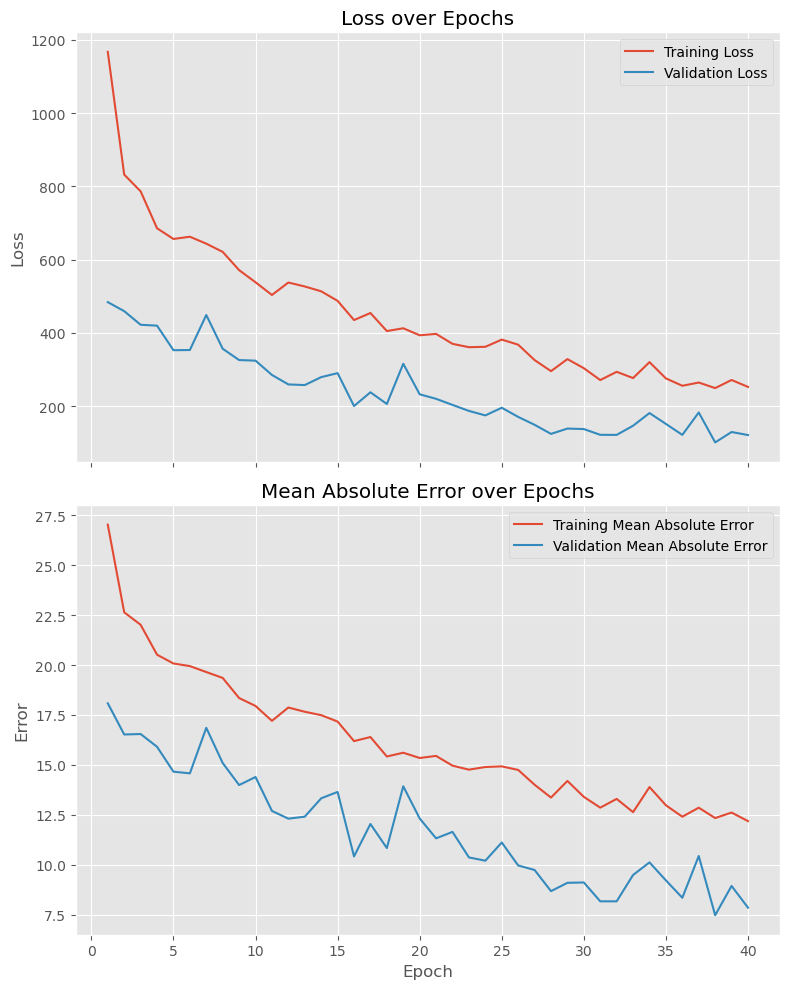

In [17]:
loss       = history.history['loss']
val_loss   = history.history.get('val_loss')
mean_absolute_error        = history.history.get('mean_absolute_error')
val_mean_absolute_error    = history.history.get('val_mean_absolute_error')

epochs = range(1, len(loss) + 1)

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 10), sharex=True)

# --- Plot Loss on top panel ---
ax1.plot(epochs, loss,   label='Training Loss')
if val_loss is not None:
    ax1.plot(epochs, val_loss, label='Validation Loss')
ax1.set_ylabel('Loss')
ax1.set_title('Loss over Epochs')
ax1.legend()
ax1.grid(True)

if mean_absolute_error is not None:
    ax2.plot(epochs, mean_absolute_error,   label='Training Mean Absolute Error')
    if val_mean_absolute_error is not None:
        ax2.plot(epochs, val_mean_absolute_error, label='Validation Mean Absolute Error')
    ax2.set_ylabel('Error')
    ax2.set_xlabel('Epoch')
    ax2.set_title('Mean Absolute Error over Epochs')
    ax2.legend()
    ax2.grid(True)
else:
    ax2.text(0.5, 0.5, 'No mean_absolute_erroruracy data found in history', 
             ha='center', va='center', transform=ax2.transAxes)

plt.tight_layout()
plt.show()
plt.show()

In [47]:
y_true = np.concatenate([y.numpy() for x, y in val_ds], axis=0)
y_pred = model.predict(val_ds).flatten()

66/66 [==============================] - 1s 20ms/step


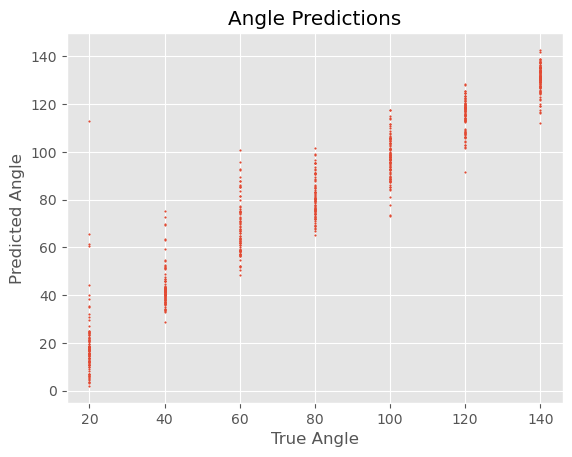

In [48]:
plt.scatter(y_true, y_pred, s= 1)
plt.ylabel("Predicted Angle")
plt.xlabel("True Angle")
plt.title("Angle Predictions")
plt.show()

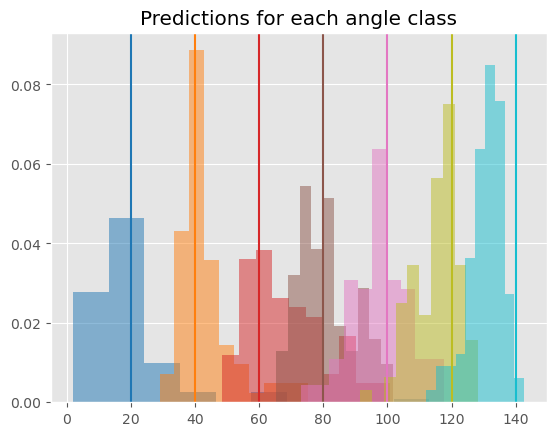

In [49]:
color = (y_true - 20) / (140 - 20)
cmap = plt.cm.tab10
for ind_color in np.unique(color):
    plt.hist(y_pred[np.where(color == ind_color)], color = cmap(ind_color), alpha = 0.5, density = True)
    plt.axvline(ind_color * (140 - 20) + 20, color = cmap(ind_color))
plt.title("Predictions for each angle class")

plt.savefig("preds.png")

In [50]:
import scipy

In [51]:
errors = y_pred.flatten() - y_true

from scipy.stats import norm
(mu, sigma) = norm.fit(errors)

x = np.arange(-50, 50, 0.1)
A = 1/(sigma * np.sqrt(2*np.pi))
y = A * np.exp((-1/2) * ((x - mu) / sigma)**2)

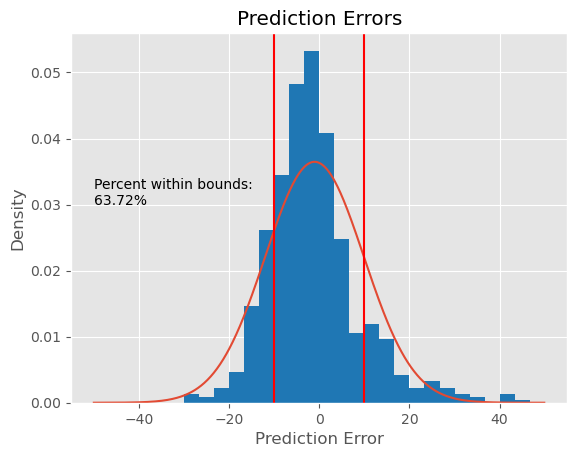

In [52]:
plt.hist(errors, bins = 30, range = [-50, 50], density = True, color = cmap(0))
plt.plot(x, y)
plt.axvline(-10, c = "red")
plt.axvline(10, c = "red")
plt.ylabel("Density")
plt.xlabel("Prediction Error")
plt.title("Prediction Errors")

p = norm.cdf(10, loc=mu, scale=sigma) - norm.cdf(-10, loc=mu, scale=sigma)
percent = p * 100
plt.text(-50, .03, "Percent within bounds: \n" + str(round(percent, 2)) + "%")
plt.savefig("pred_errors.png")